### Visualization
In this notebook, we explore different strategies to make sense of the datasets.

We plot a sample signal from each class, and then use PCA to attempt to visualize a representative subset of the datasets.

We also visualize the embeddings resulting from the final convolutional layer of the [Baseline Model](baseline/Baseline_mitbih.ipynb), with much better results.

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.decomposition as decomposition
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score

### Load training mit dataset

In [2]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
Dataset seems to be quite unbalanced

In [4]:
unique, counts = np.unique(Y, return_counts=True)
list(zip(unique.tolist(), counts.tolist()))

[(0, 72471), (1, 2223), (2, 5788), (3, 641), (4, 6431)]

### Plot one of each label

In [5]:
label_index = {i: np.where(Y == i)[0].tolist() for i in range(0, 5)}

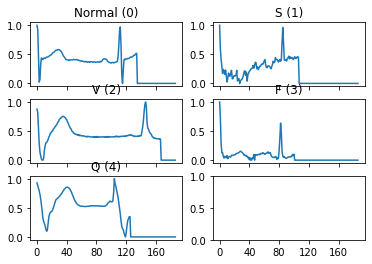

In [6]:
fig,a =  plt.subplots(3,2, sharex='col')
plt.setp(a, xticks=[i*20 for i in range(0, 11, 2)], xticklabels=[i*20 for i in range(0, 11, 2)])

a[0][0].plot(X[label_index[0][0], :])
a[0][0].set_title('Normal (0)')
a[0][1].plot(X[label_index[1][0], :])
a[0][1].set_title('S (1)')
a[1][0].plot(X[label_index[2][0], :])
a[1][0].set_title('V (2)')
a[1][1].plot(X[label_index[3][0], :])
a[1][1].set_title('F (3)')
a[2][0].plot(X[label_index[4][0], :])
a[2][0].set_title('Q (4)')
plt.show()

### Define subset of data to be used for visualization

In [4]:
subset_size = 5000
X_centered = X - X.mean(axis=0)
subset = np.random.randint(X.shape[0], size=(subset_size))

### Dimensionality reduction with PCA
PCA represents the data using the directions of greatest variance as the new basis

In [8]:
X.shape

(87554, 187, 1)

### PCA on the raw data does not reveal a very separable structure
This suggests simplet linear models would most likely not preform well on the raw data

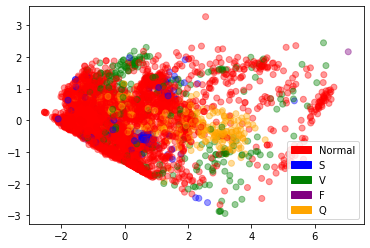

In [9]:
colors = ['r', 'b', 'g', 'purple', 'orange']
label_names = ['Normal', 'S', 'V', 'F', 'Q']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(5)]
pca = decomposition.PCA(n_components=2)
components = pca.fit_transform(X_centered.squeeze()[subset])
sc = plt.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

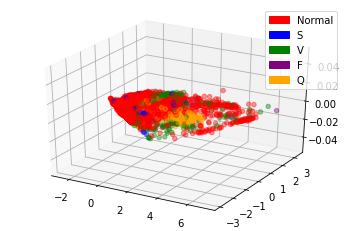

In [10]:
colors = ['r', 'b', 'g', 'purple', 'orange']
label_names = ['Normal', 'S', 'V', 'F', 'Q']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(5)]
pca = decomposition.PCA(n_components=3)
components = pca.fit_transform(X_centered.squeeze()[subset])
ax = plt.subplot(111, projection='3d')
ax.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
            c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

### PCA/t-SNE from embeddings
We use the baseline model to obtain lower dimensional representation of each datapoint, by extracting it from the last convolutional layer.

We first still apply PCA to this in order to reduce the dimensionality further, otherwise t-sne takes a very long time.

In t-sne, similar datapoints are spatially close with a high probability.

In [44]:
model = load_model("baseline/baseline_cnn_mitbih.h5")
embeding_model = Model(inputs=model.inputs, outputs=model.layers[15].output) # get embeddings from last conv layer

embedings = embeding_model.predict(X)
embedings.shape

(87554, 256)

In [45]:
embeddings_centered = embedings - embedings.mean(axis=0)
pca = decomposition.PCA(n_components=50)
embedings_reduced = pca.fit_transform(embeddings_centered[subset])
t_sne = TSNE(n_components=2).fit_transform(embedings_reduced)

### t-SNE on the embeddings shows a clear separation between classes, even for the rare F class
The representation obtained from the baseline cnn reveals a much more separable structure

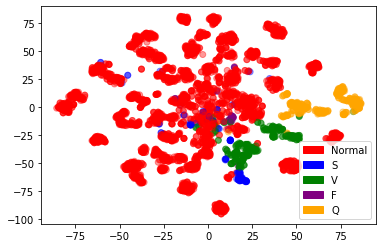

In [46]:
colors = ['r', 'b', 'g', 'purple', 'orange']
label_names = ['Normal', 'S', 'V', 'F', 'Q']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(5)]
sc = plt.scatter([t_sne[i, 0] for i in range(subset_size)], [t_sne[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

#### PCA also reveals a clear structure in the data, although it is perhaps not as clear as t-sne, especially for the F class

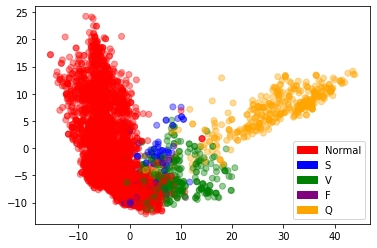

In [47]:
colors = ['r', 'b', 'g', 'purple', 'orange']
label_names = ['Normal', 'S', 'V', 'F', 'Q']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(5)]
pca = decomposition.PCA(n_components=2)
components = pca.fit_transform(embeddings_centered.squeeze()[subset])
sc = plt.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

### Attempt to cluster with K-means on the embeddings
Here we do train K-means on using the full training set on the embeddings produced by the baseline model.

What is shown is the prediction for the same subset of points as above, shown in the PCA and t-sne basis.

We observe that classes Q and V are very clearly clusterable. However, K-means seems to struggle in differentiating between class normal and S. This is understandable from either of the projections as these 2 classes seem to overlap the most.

In [48]:
clf = KMeans(n_clusters=5).fit(embedings)
y_means = clf.predict(embedings[subset])

Text(0.5, 0.98, 'Top: Ground Truth; Bottom: K-means clusters(K=5)')

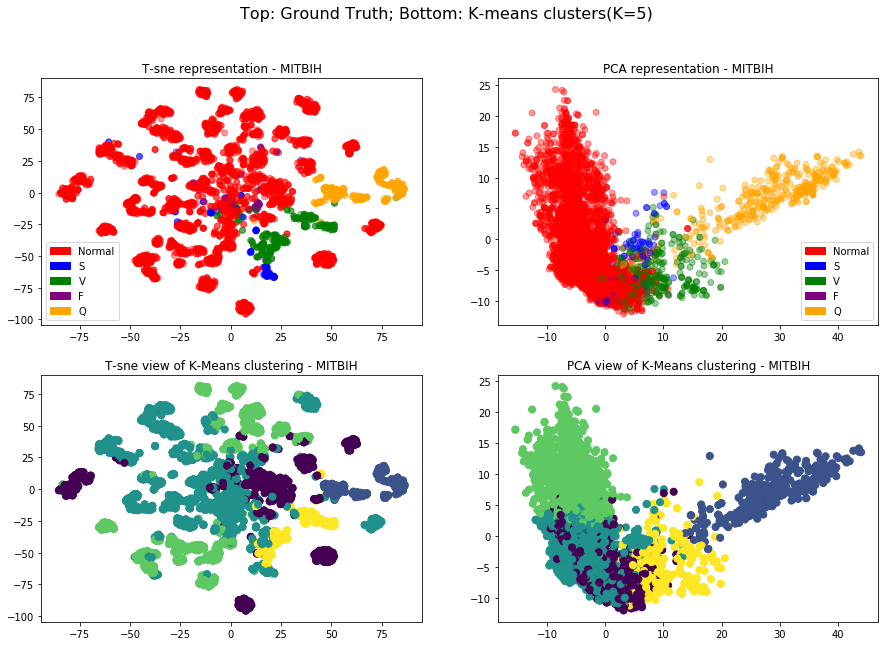

In [49]:
colors = ['r', 'b', 'g', 'purple', 'orange']
label_names = ['Normal', 'S', 'V', 'F', 'Q']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(5)]
fig,a = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
a[0][0].scatter([t_sne[i, 0] for i in range(subset_size)], [t_sne[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
a[0][0].legend(handles=colors_artists)
a[0][0].set_title('T-sne representation - MITBIH')
a[1][0].scatter(t_sne[:, 0], t_sne[:, 1], c=y_means, s=50, cmap='viridis')
a[1][0].set_title('T-sne view of K-Means clustering - MITBIH')
a[1][1].scatter(components[:, 0], components[:, 1], c=y_means, s=50, cmap='viridis')
a[1][1].set_title('PCA view of K-Means clustering - MITBIH')
a[0][1].scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
a[0][1].legend(handles=colors_artists)
a[0][1].set_title('PCA representation - MITBIH')
fig.suptitle('Top: Ground Truth; Bottom: K-means clusters(K=5)', fontsize=16)

## We now follow the same approach for the ptbdb dataset

### Load training ptbdb training dataset

In [13]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train_pt, df_test_pt = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y_pt = np.array(df_train_pt[187].values).astype(np.int8)
X_pt = np.array(df_train_pt[list(range(187))].values)[..., np.newaxis]

Y_test_pt = np.array(df_test_pt[187].values).astype(np.int8)
X_test_pt = np.array(df_test_pt[list(range(187))].values)[..., np.newaxis]

### Normal vs Abnormal count
Once more, quite unbalanced dataset, with abnormal having more than double the datapoints of normal

In [68]:
df_1.shape[0], df_2.shape[0]

(4046, 10506)

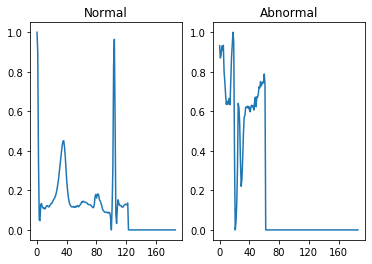

In [21]:
fig,a = plt.subplots(1,2, sharex='col')
plt.setp(a, xticks=[i*20 for i in range(0, 11, 2)], xticklabels=[i*20 for i in range(0, 11, 2)])

a[0].plot(df_1.iloc[0, :187])
a[0].set_title('Normal')
a[1].plot(df_2.iloc[0, :187])
a[1].set_title('Abnormal')
plt.show()

### Define subset of data to be used for visualization

In [14]:
subset_size = 5000
X_centered_pt = X_pt - X_pt.mean(axis=0)
subset = np.random.randint(X_pt.shape[0], size=(subset_size))

### Similarly for this dataset, PCA does not show such a clear separation

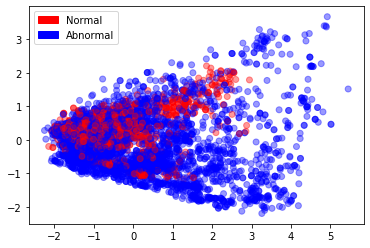

In [15]:
colors = ['r', 'b']
label_names = ['Normal', 'Abnormal']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(2)]
pca = decomposition.PCA(n_components=2)
components = pca.fit_transform(X_centered_pt.squeeze()[subset])
sc = plt.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

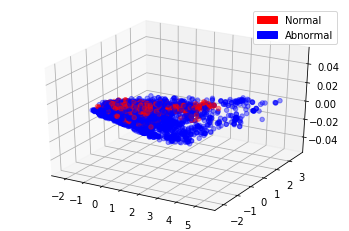

In [16]:
colors = ['r', 'b']
label_names = ['Normal', 'Abnormal']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(2)]
pca = decomposition.PCA(n_components=3)
components = pca.fit_transform(X_centered_pt.squeeze()[subset])
ax = plt.subplot(111, projection='3d')
ax.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
            c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

### t-SNE from embeddings

In [32]:
model = load_model("baseline/baseline_cnn_ptbdb.h5")
embeding_model_pt = Model(inputs=model.inputs, outputs=model.layers[15].output) # get embeddings from last conv layer

In [33]:
embedings_pt = embeding_model_pt.predict(X_pt)
embedings_pt.shape

(11641, 256)

In [34]:
embeddings_centered_pt = embedings_pt - embedings_pt.mean(axis=0)
pca = decomposition.PCA(n_components=50)
embedings_reduced = pca.fit_transform(embeddings_centered_pt[subset])
t_sne = TSNE(n_components=2).fit_transform(embedings_reduced)

### But t-sne shows a much clearer separation between both classes

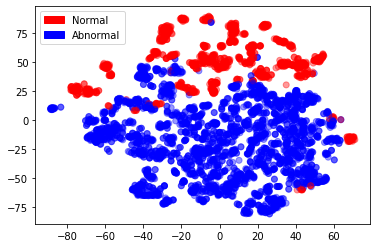

In [35]:
colors = ['r', 'b']
label_names = ['Normal', 'Abnormal']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(2)]
sc = plt.scatter([t_sne[i, 0] for i in range(subset_size)], [t_sne[i, 1] for i in range(subset_size)],
                 c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.4)
plt.legend(handles=colors_artists)

### The PCA plot is not as clearly separable, with considerable overlap of both classes

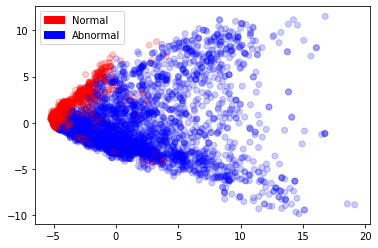

In [36]:
colors = ['r', 'b']
label_names = ['Normal', 'Abnormal']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(2)]
pca = decomposition.PCA(n_components=2)
components = pca.fit_transform(embeddings_centered_pt.squeeze()[subset])
sc = plt.scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.2)
plt.legend(handles=colors_artists)

### Attempt to cluster with K-means on the embeddings
In this dataset, K-means has a much harder time, being very difficult for us to understand any underlying structure identified by K-means.

In [37]:
clf = KMeans(n_clusters=2).fit(embedings)
y_means = clf.predict(embedings[subset])

Text(0.5, 0.98, 'Top: Ground Truth; Bottom: K-means clusters(K=2)')

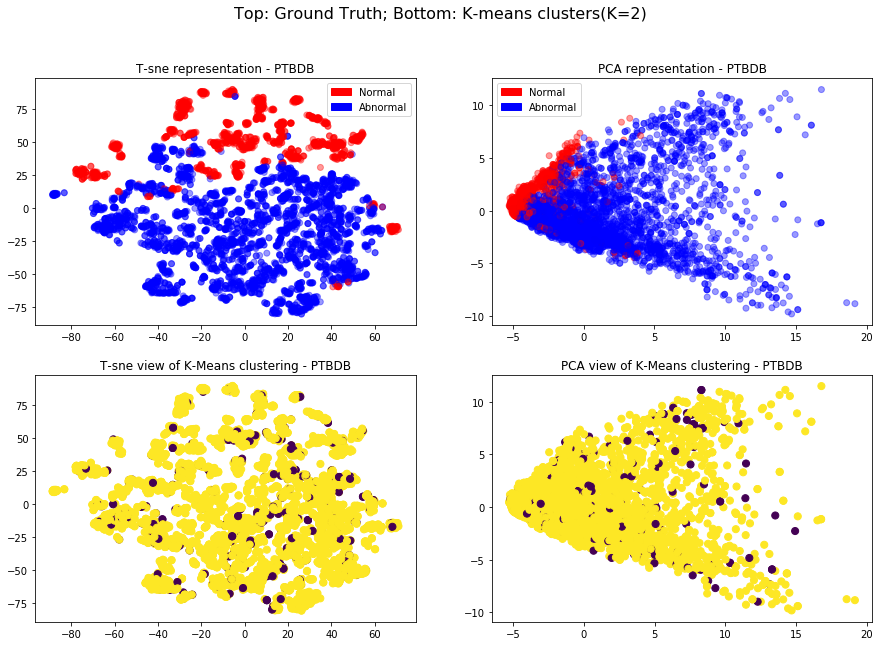

In [38]:
fig,a = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
a[0][0].scatter([t_sne[i, 0] for i in range(subset_size)], [t_sne[i, 1] for i in range(subset_size)],
                 c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.4)
a[0][0].legend(handles=colors_artists)
a[0][0].set_title('T-sne representation - PTBDB')
a[1][0].scatter(t_sne[:, 0], t_sne[:, 1], c=y_means, s=50, cmap='viridis')
a[1][0].set_title('T-sne view of K-Means clustering - PTBDB')
a[1][1].scatter(components[:, 0], components[:, 1], c=y_means, s=50, cmap='viridis')
a[1][1].set_title('PCA view of K-Means clustering - PTBDB')
a[0][1].scatter([components[i, 0] for i in range(subset_size)], [components[i, 1] for i in range(subset_size)],
                 c=[colors[Y_pt[subset[i]]] for i in range(subset_size)], label=[Y_pt[subset[i]] for i in range(subset_size)], alpha=0.4)
a[0][1].legend(handles=colors_artists)
a[0][1].set_title('PCA representation - PTBDB')
fig.suptitle('Top: Ground Truth; Bottom: K-means clusters(K=2)', fontsize=16)